In [1]:
import sys
import utm
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import context
from utils import *
import PyPL

## Plot Color/Symbols Legend
### Inputs
- <span style="color:purple">External Boundary Box</span>.
- <span style="color:orange">Headland Boundary Box</span>.
- <span style="color:darkgreen">Start Pose</span>.
- <span style="color:magenta">End Pose</span>.

### Outputs
- <span style="color:blue">Implement Path Line</span>.
- <span style="color:lightgreen">Track lines</span>.

local start: [ 5. 15.]
local end: [-10. -30.]


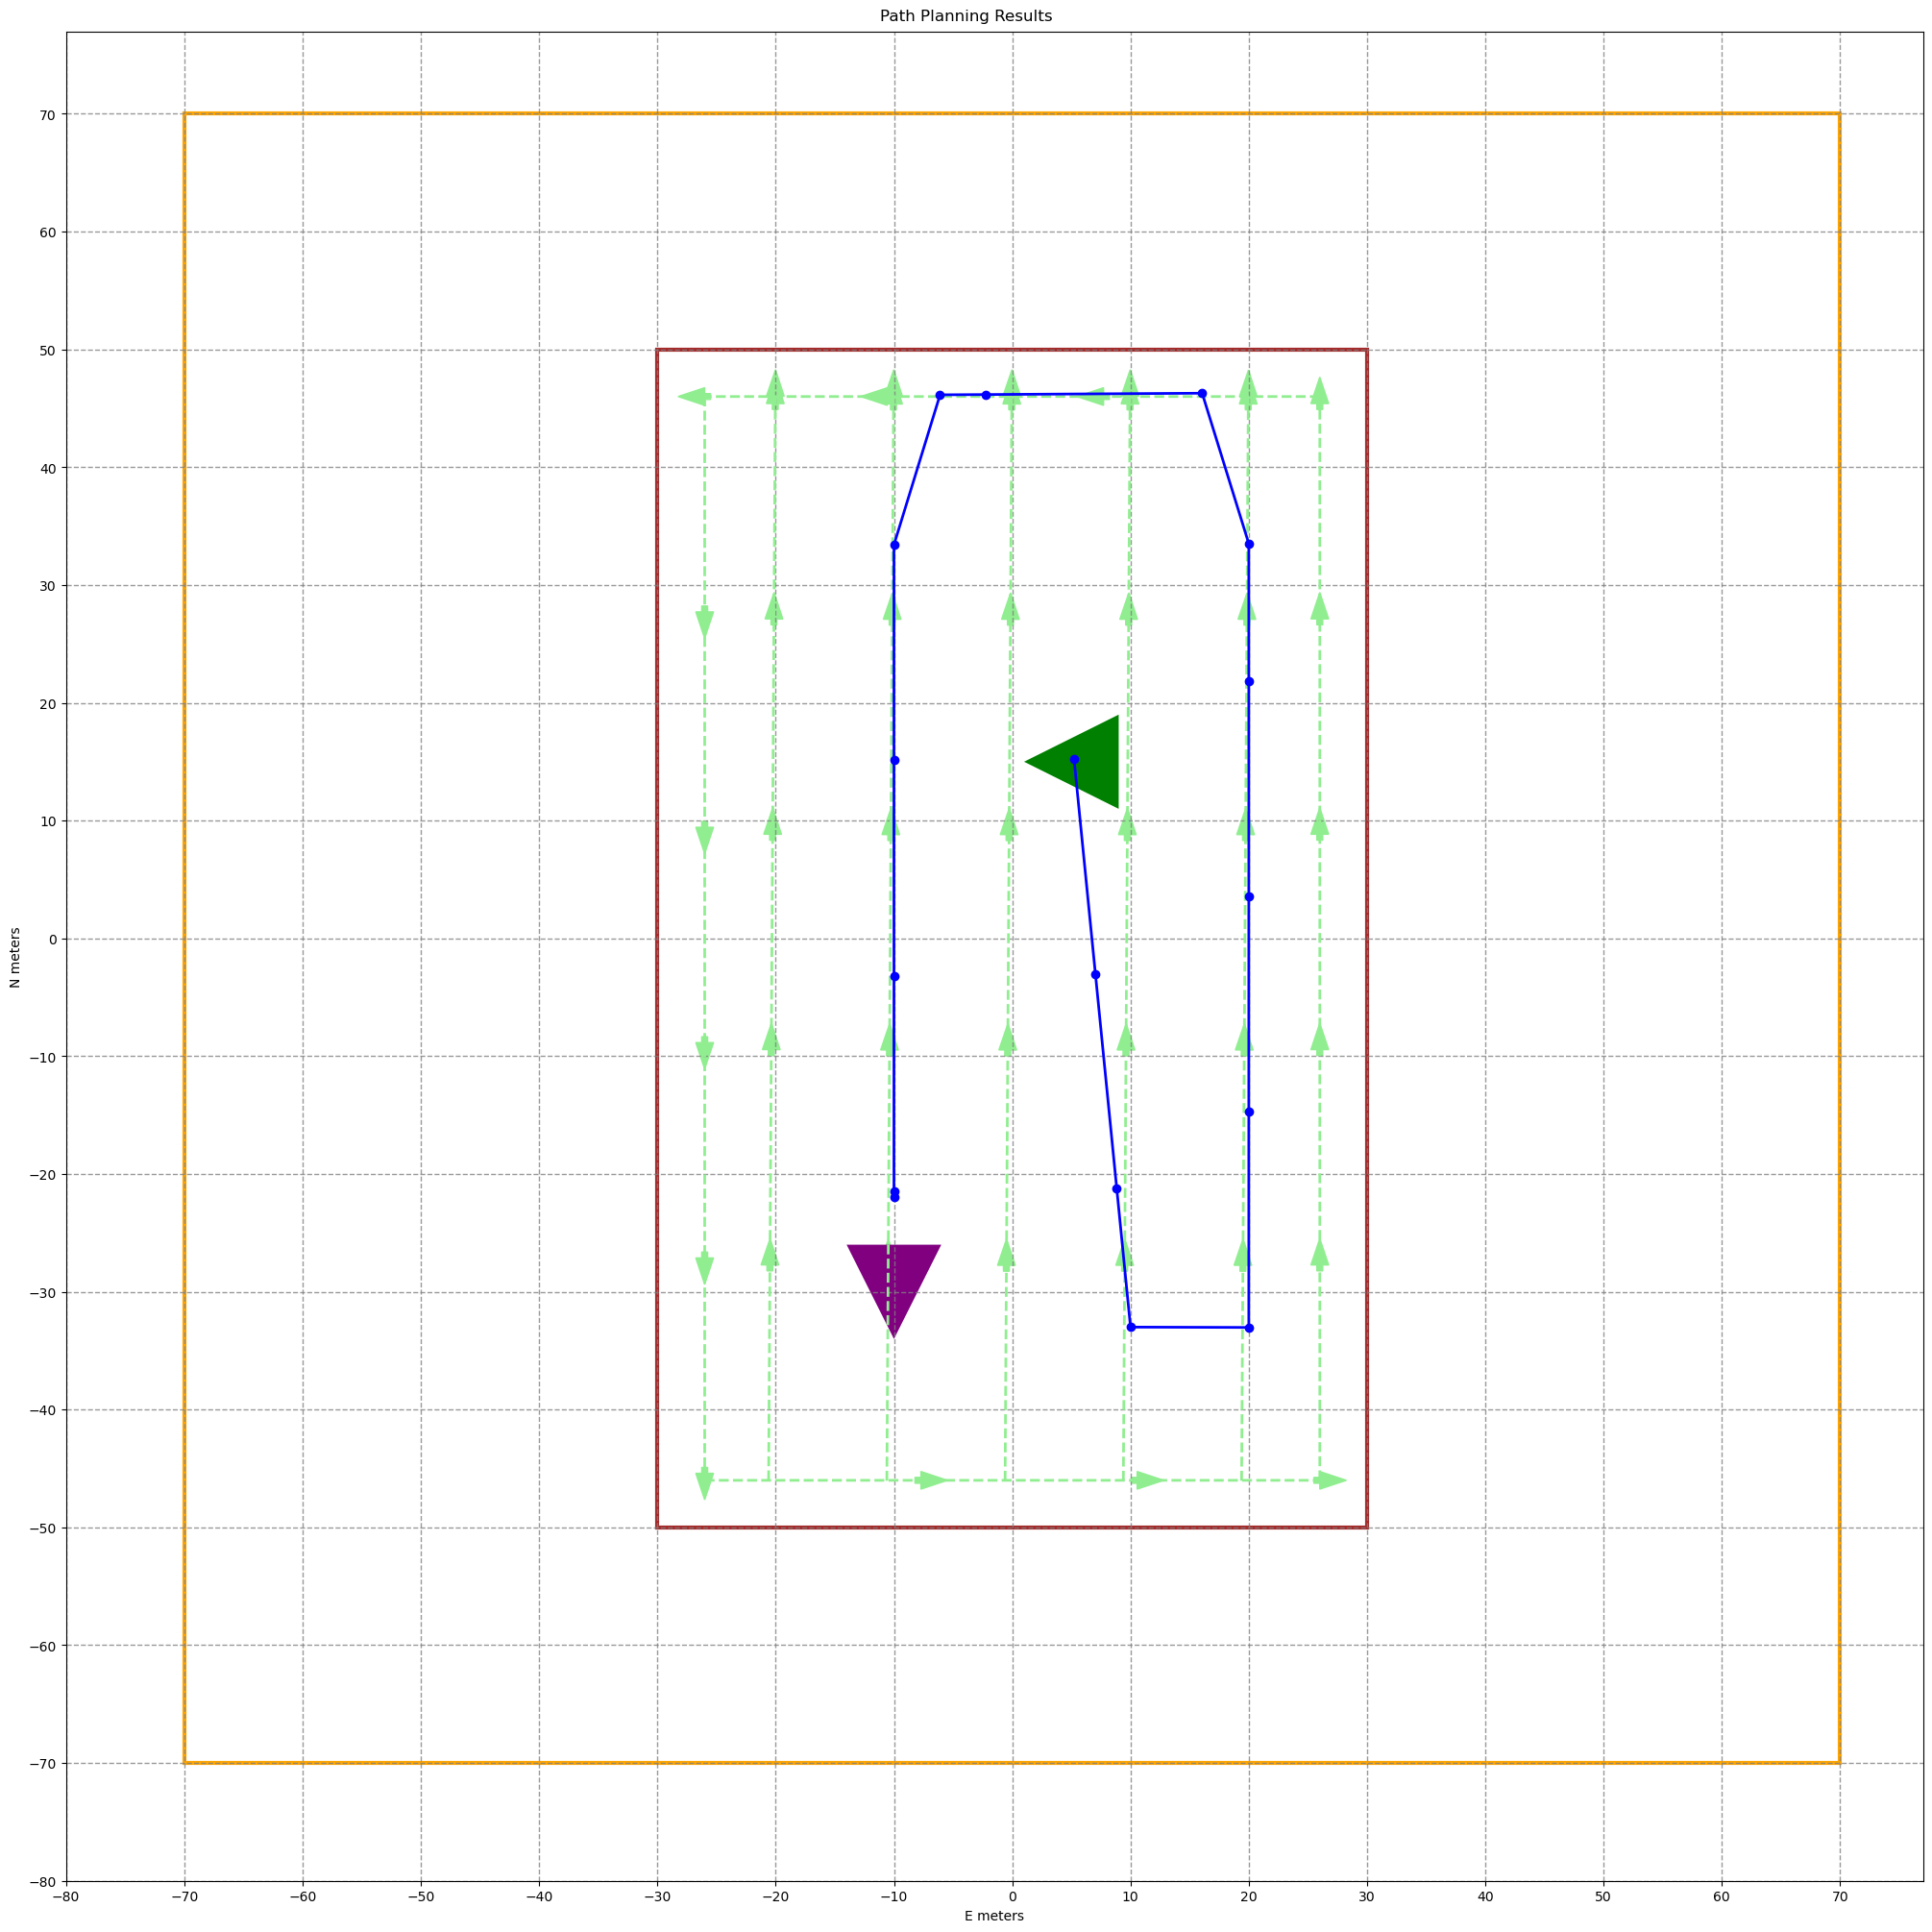

In [2]:
# Planning Scenerio 4.1
# Planner Type: RoadNetwork planner
# Description:
# - Headland boundary exceeds exterior boundaries
# - Start pose is 5m off track line
# - Start and End pose angle off by 90 degrees

track_spacing = 10.0
in_ground_turning_radius = 6.0
vehicle_width = 0.8 * track_spacing
implement_width = 0.8 * track_spacing
work_heading = 0.0 #90.0boundaries_plot_attributes
planning_strategy = PyPL.PlanningStrategy.HeadingOnly
obstacles_buffer = 0.0 # Described as ExtraBuffer, the effects of this parameter arent't well understood
''' 
Options for environment_inputs.Strategy are listed below
    SnapToBoundary, # Appears to produce results similar to "ExistingTrack"
    BestFitSnapToBoundary, # Causes the plannig library to crash
    HeadingOnly,
    ExistingTrack
'''
origin_latlon = (41.74850266356132, -93.53101140091728)
origin_easting, origin_northing, zone_number, zone_letter = utm.from_latlon(origin_latlon[0], origin_latlon[1])
origin_xy = np.asarray([origin_easting, origin_northing])

# Plot grid attributes
grid_size = np.arange(-80, 80, track_spacing)

# Path inputs
start_xy = origin_xy + np.asarray([5.0, 1.5 * track_spacing])
end_xy = origin_xy + np.asarray([-1.0 * track_spacing, -3.0 * track_spacing])
print('local start: {}'.format(str(start_xy - origin_xy)))
print('local end: {}'.format(str(end_xy - origin_xy)))

start_pose_2d = Pose2D(start_xy, 180.0, zone_number, zone_letter)
goal_pose_2d = Pose2D(end_xy, 270, zone_number, zone_letter)

# Building obstacles
obstacles_plot_attributes = {'edgecolor':'green',
                               'linewidth': 3,
                               'facecolor': 'green'}
obstacles = [
    Box2D.create_box(origin_xy + np.asarray([-5.0 * track_spacing, 0]),  4.0 * track_spacing, 10.0* track_spacing, **obstacles_plot_attributes),
    Box2D.create_box(origin_xy + np.asarray([5.0 * track_spacing, 0]),  4.0 * track_spacing, 10.0* track_spacing, **obstacles_plot_attributes),
]

padding = [-4.0 * track_spacing, 0.0]
boundaries_plot_attributes = {'edgecolor':'brown'}
boundaries = [Box2D.compute_bounding_box(obstacles, padding, **boundaries_plot_attributes)]
headland_boundaries = [Box2D.compute_bounding_box(obstacles, [0.0 * track_spacing, 2.0 * track_spacing], **boundaries_plot_attributes)]
environment_objects = EnvironmentObjects([], boundaries, headland_boundaries)

plan_constraints = build_planning_env(origin_xy, zone_number, zone_letter,
                                      environment_objects,
                                      track_spacing,
                                      in_ground_turning_radius,
                                      vehicle_width,
                                      implement_width,
                                      work_heading,
                                      planning_strategy,
                                      obstacles_buffer)

environment_inputs = plan_constraints.environment_inputs
environment_inputs.TopBottom = True

plan_results = generate_road_network_path((start_pose_2d, goal_pose_2d), plan_constraints)
output_path_offset = boundaries[0].top_left - origin_xy
fig, axs = plot_planning_results(plan_constraints,
                                 plan_results,
                                 output_path_offset,
                                 grid_size,
                                 implement_width,
                                 implement_width)

### Observations:
- Path line is not as dense a that generated by OpenField planner
- Path does not reach End Pose
- Path does not show curvatures necessary for turning
- Removal of large and small obstacles was necessary in order for the planner to generate paths consistenly
- External and Headland boundaries were specified, the path is confined to the boundary when **environment_inputs.TopBottom = True**

local start: [10. 20.]
local end: [-10. -30.]


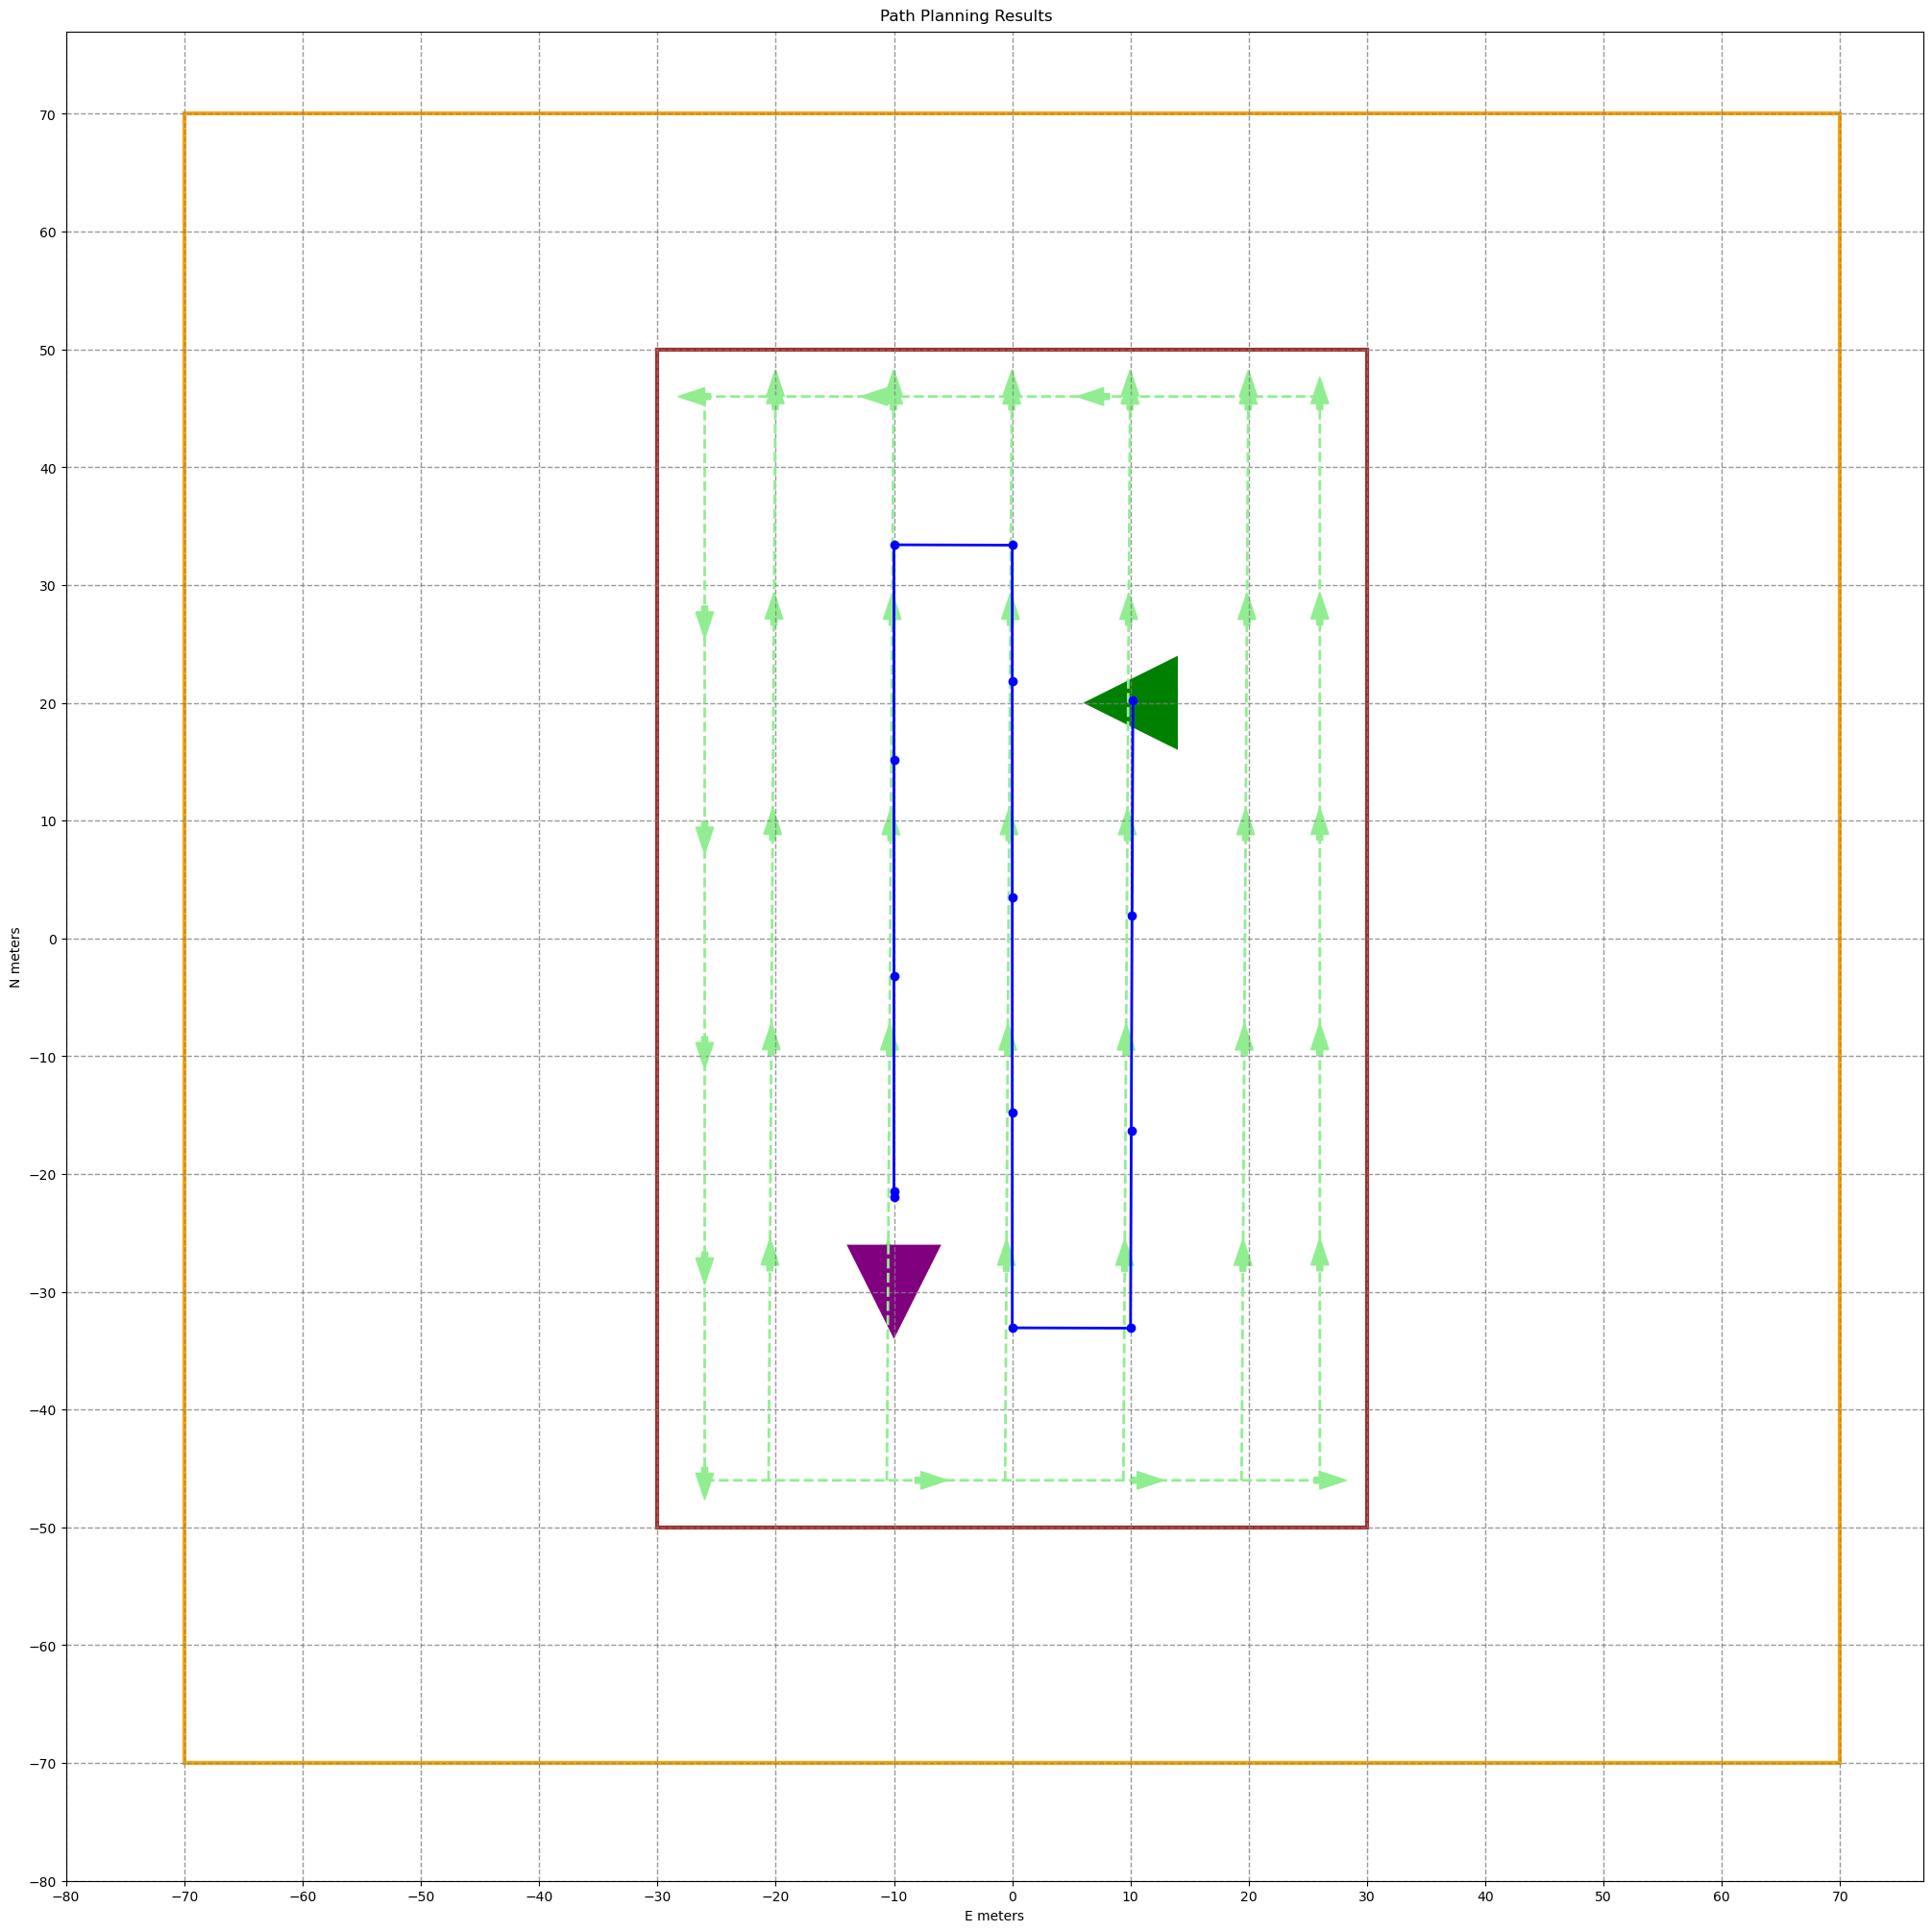

In [3]:
# Planning Scenerio 4.2
# Planner Type: RoadNetwork planner
# Description:
# - Headland boundary exceeds exterior bounday's reach
# - Start pose is on a track line
# - Start and End pose angle off by 90 degrees
output path but it isn't clear how as the the planner generated sig
# Path inputs
start_xy = origin_xy + np.asarray([10.0, 2.0 * track_spacing])
end_xy = origin_xy + np.asarray([-1.0 * track_spacing, -3.0 * track_spacing])
print('local start: {}'.format(str(start_xy - origin_xy)))
print('local end: {}'.format(str(end_xy - origin_xy)))

start_pose_2d = Pose2D(start_xy, 180.0, zone_number, zone_letter)
goal_pose_2d = Pose2D(end_xy, 270, zone_number, zone_letter)

# Building obstacles

padding = [-40.0, 0.0]
boundaries_plot_attributes = {'edgecolor':'brown'}
boundaries = [Box2D.compute_bounding_box(obstacles, padding, **boundaries_plot_attributes)]
headland_boundaries = [Box2D.compute_bounding_box(obstacles,[0.0 * track_spacing, 2.0 * track_spacing], **boundaries_plot_attributes)]

environment_inputs = plan_constraints.environment_inputs
plan_constraints.environment_objects.headland_boundaries = headland_boundaries
environment_inputs.HeadlandBoundaries = box2d_to_pypl_points(headland_boundaries, zone_number, zone_letter)
environment_inputs.TopBottom = True

plan_results = generate_road_network_path((start_pose_2d, goal_pose_2d), plan_constraints)
output_path_offset = boundaries[0].top_left - origin_xy
fig, axs = plot_planning_results(plan_constraints,
                                 plan_results,
                                 output_path_offset,
                                 grid_size,
                                 implement_width,
                                 implement_width)

### Observations:
- Path **does not** reach End Pose
- Path taken is significantly different than previous one, only difference in inputs is that the start is on a line track

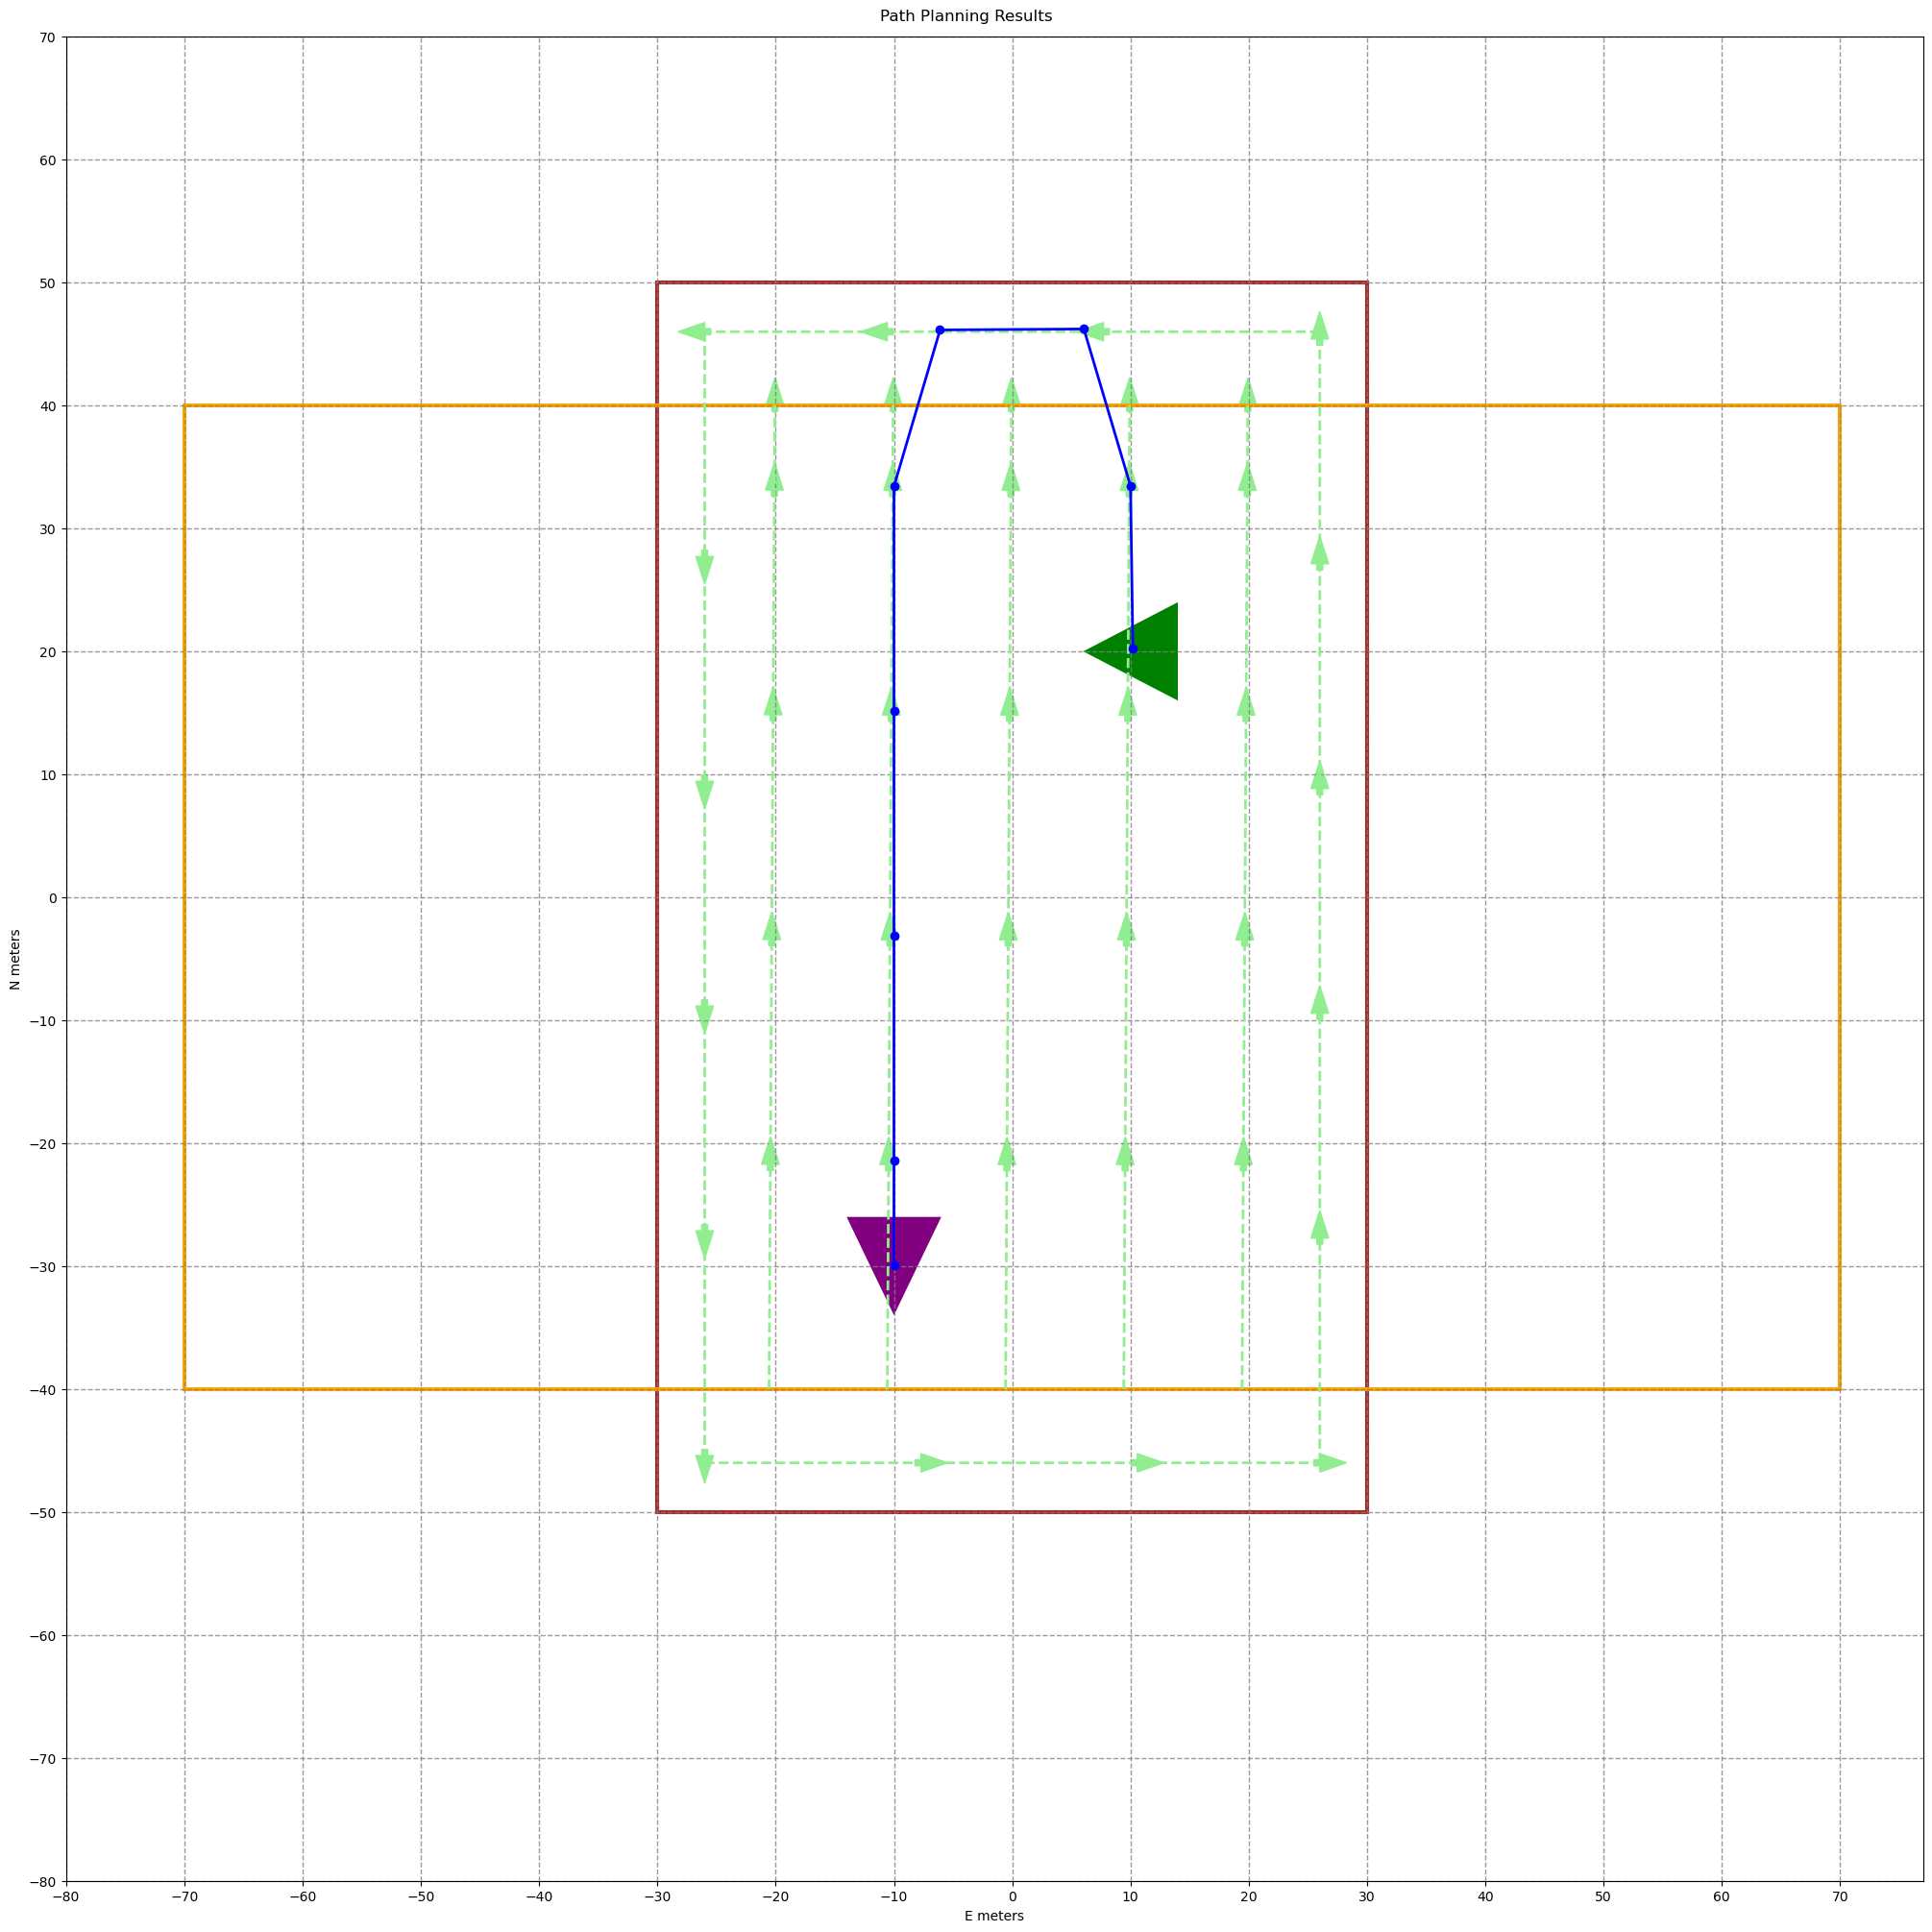

In [4]:
# Planning Scenerio 4.3
# Planner Type: RoadNetwork planner
# Description:
# - Headland boundary  width exceeds exterior boundary's width
# - Start pose is on a track line
# - Start and End pose angle off by 90 degrees

headland_boundaries = [Box2D.compute_bounding_box(obstacles, [0.0 * track_spacing, -1.0 * track_spacing], **boundaries_plot_attributes)]

environment_inputs = plan_constraints.environment_inputs
plan_constraints.environment_objects.headland_boundaries = headland_boundaries
environment_inputs.HeadlandBoundaries = box2d_to_pypl_points(headland_boundaries, zone_number, zone_letter)
environment_inputs.TopBottom = True

plan_results = generate_road_network_path((start_pose_2d, goal_pose_2d), plan_constraints)
output_path_offset = boundaries[0].top_left - origin_xy
fig, axs = plot_planning_results(plan_constraints,
                                 plan_results,
                                 output_path_offset,
                                 grid_size,
                                 implement_width,
                                 implement_width)

### Observations:
- Path **DOES** reach End Pose
- Path taken is significantly different than previous one, it goes all the way to the headland track

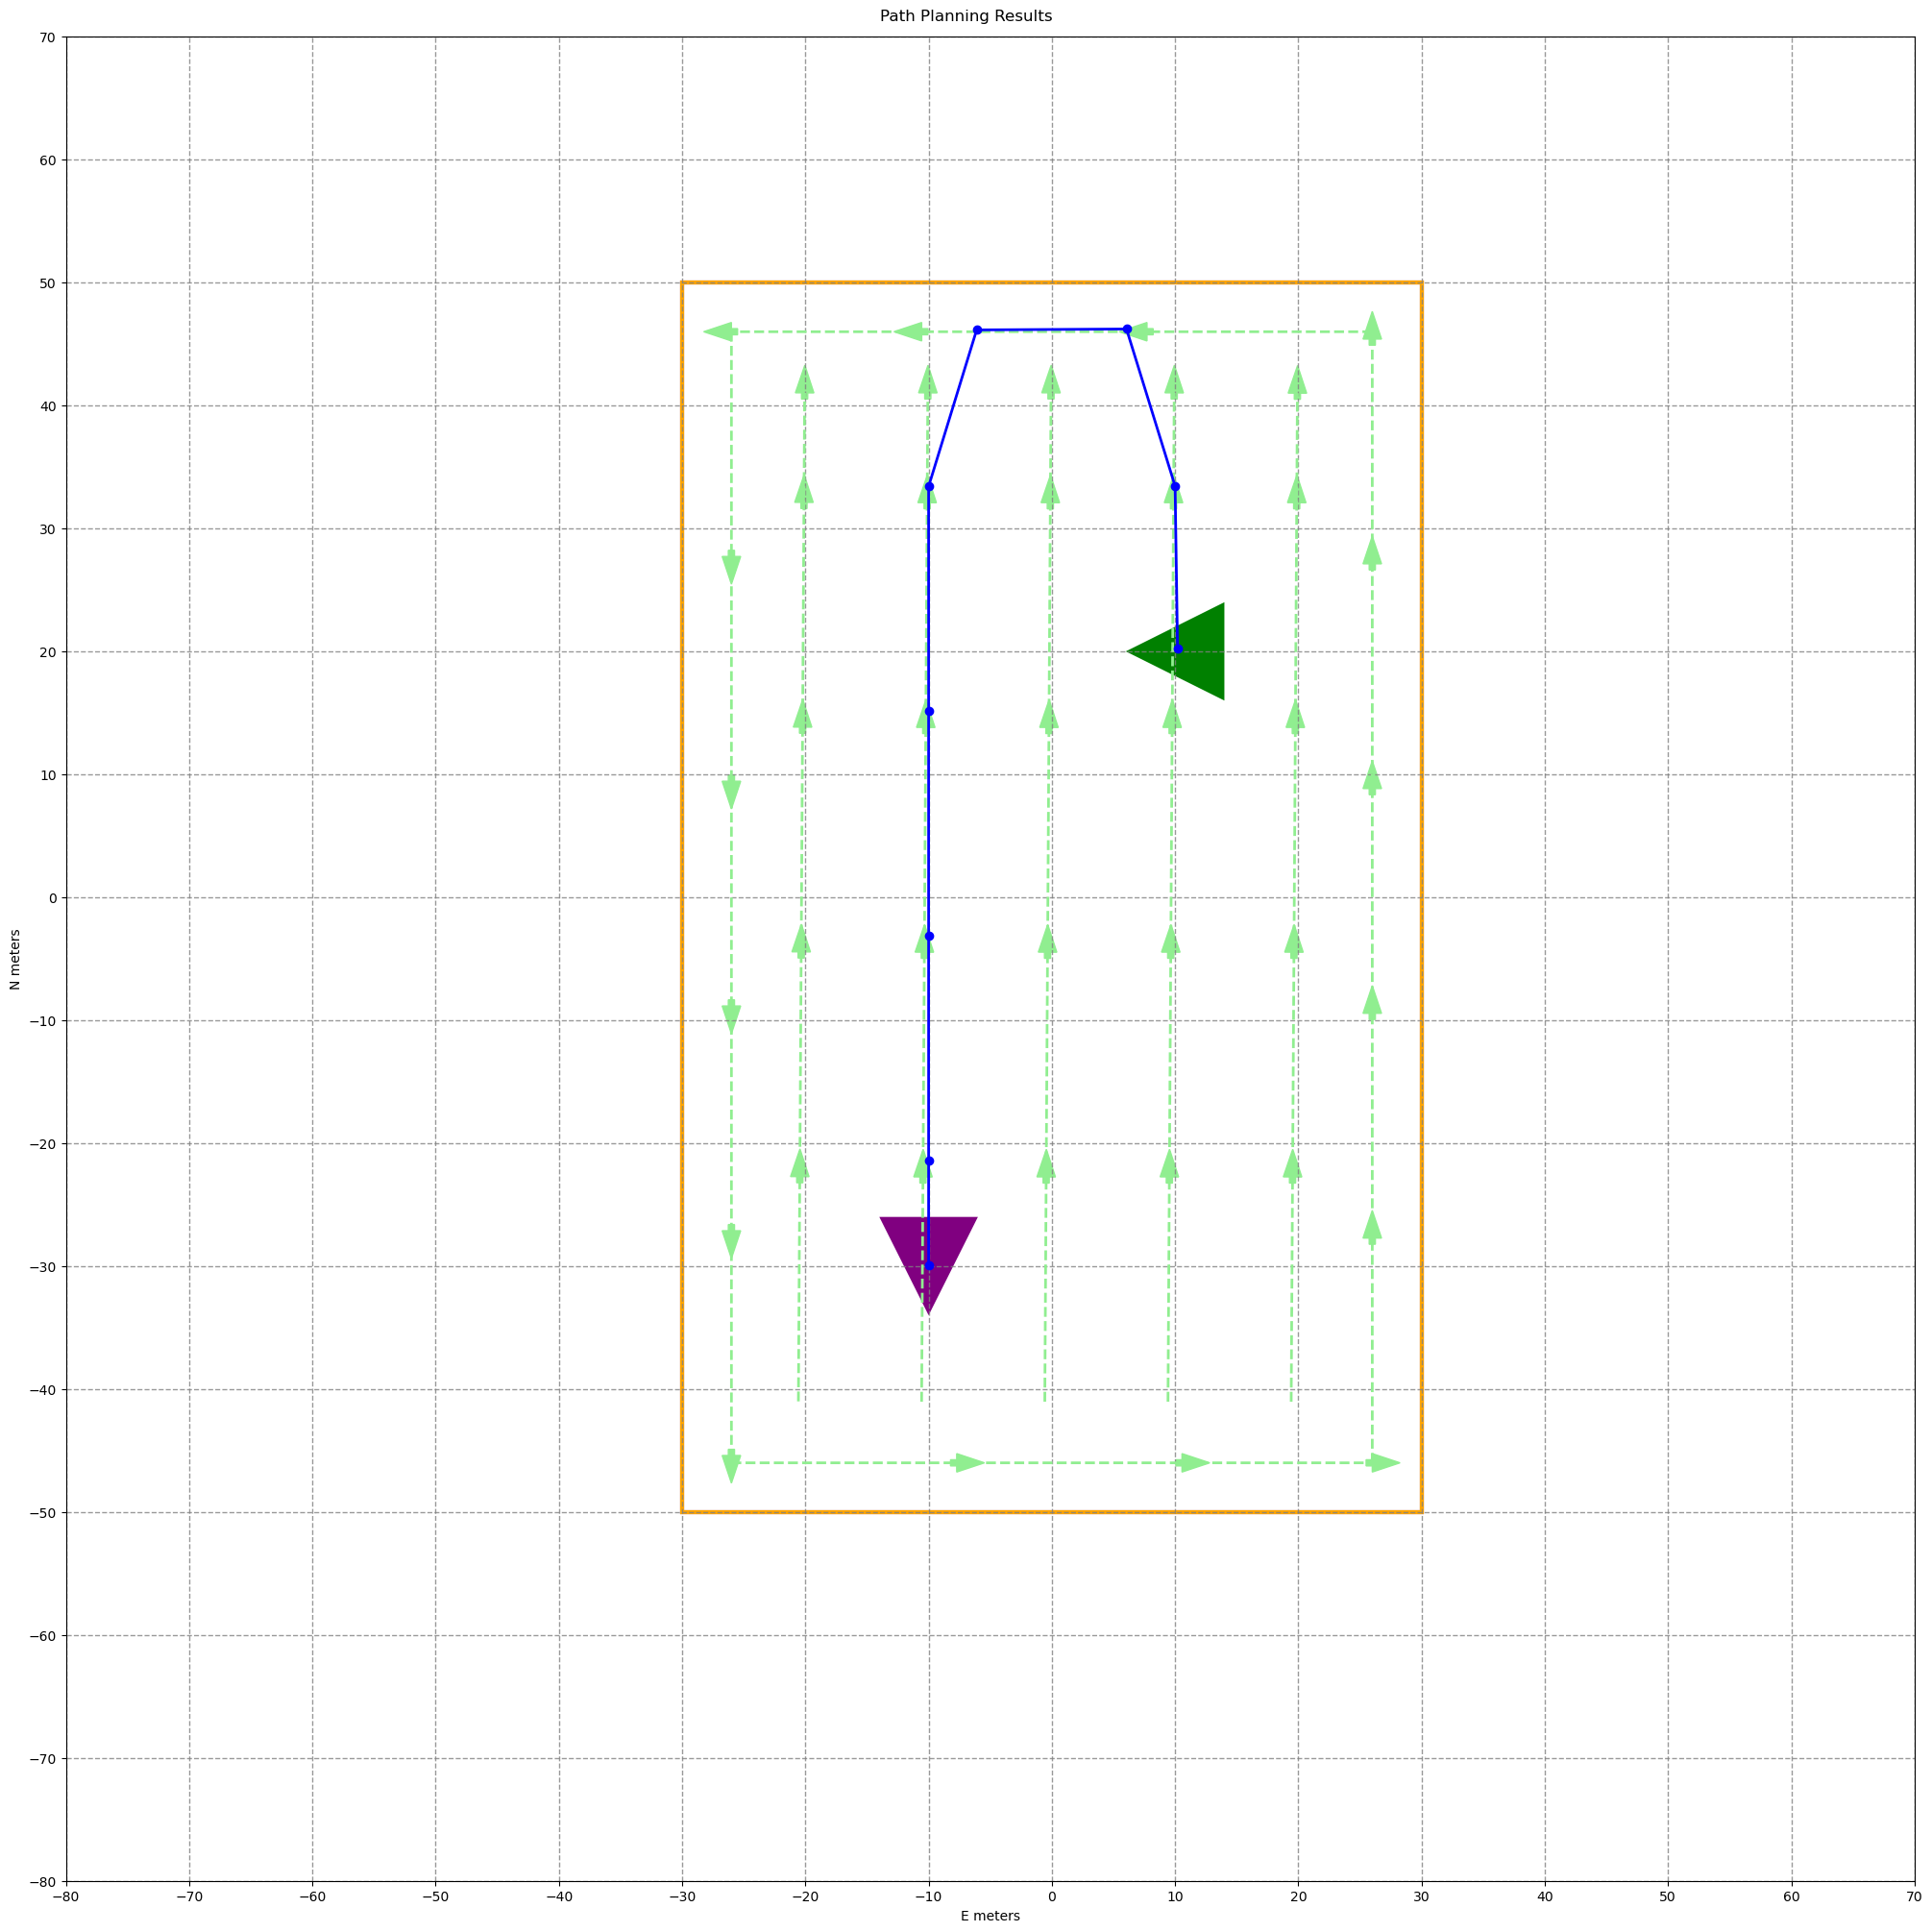

In [5]:
# Planning Scenerio 4.4
# Planner Type: RoadNetwork planner
# Description:
# - Headland and exterior boundaries overlap
headland_boundaries = [Box2D.compute_bounding_box(obstacles, [-4.0 * track_spacing, 0.0 * track_spacing], **boundaries_plot_attributes)]

environment_inputs = plan_constraints.environment_inputs
plan_constraints.environment_objects.headland_boundaries = headland_boundaries
environment_inputs.HeadlandBoundaries = box2d_to_pypl_points(headland_boundaries, zone_number, zone_letter)
environment_inputs.TopBottom = True


plan_results = generate_road_network_path((start_pose_2d, goal_pose_2d), plan_constraints)
output_path_offset = boundaries[0].top_left - origin_xy
fig, axs = plot_planning_results(plan_constraints,
                                 plan_results,
                                 output_path_offset,
                                 grid_size,
                                 implement_width,
                                 implement_width)

### Observations:
- Path **DOES** reach End Pose
- Path taken **appears to be the same** as the previous one, it goes all the way to the headland track

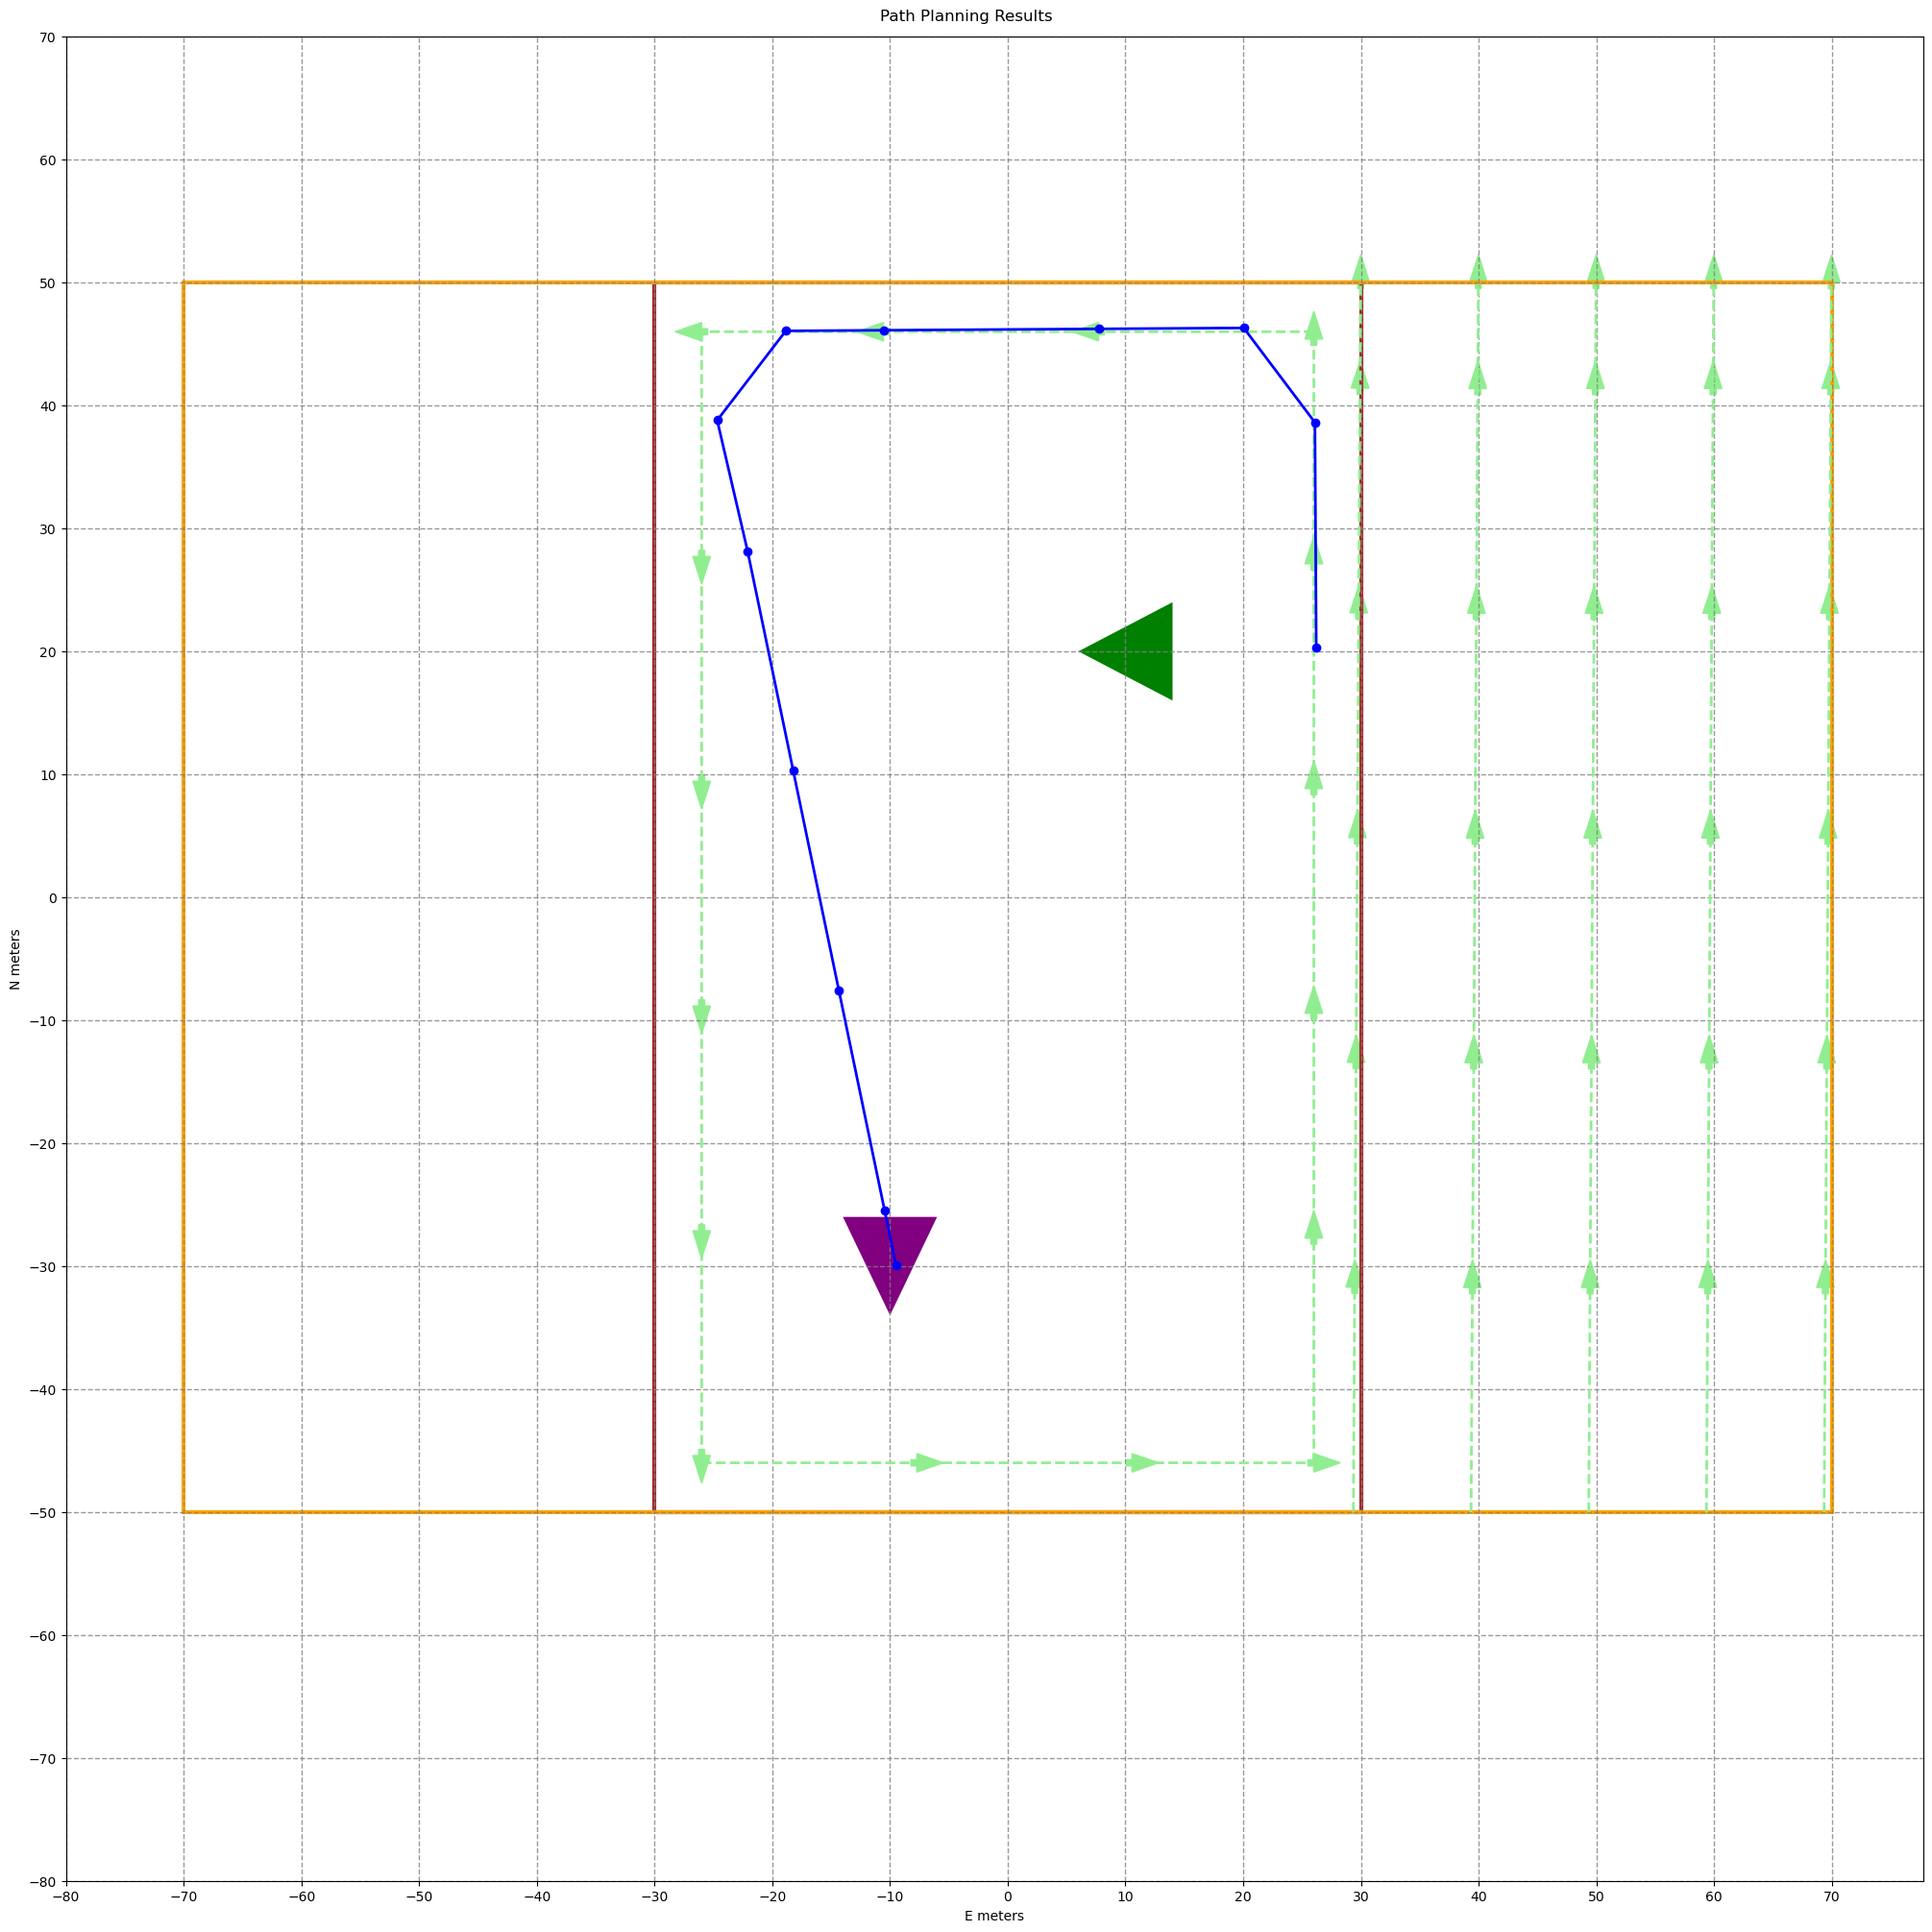

In [6]:
# Planning Scenerio 4.5
# Planner Type: RoadNetwork planner
# Description:
# - Headland and exterior boundaries have the same height
headland_boundaries = [Box2D.compute_bounding_box(obstacles, [0.0 * track_spacing, 0.0 * track_spacing], **boundaries_plot_attributes)]
environment_inputs = plan_constraints.environment_inputs
plan_constraints.environment_objects.headland_boundaries = headland_boundaries
environment_inputs.HeadlandBoundaries = box2d_to_pypl_points(headland_boundaries, zone_number, zone_letter)

plan_results = generate_road_network_path((start_pose_2d, goal_pose_2d), plan_constraints)
output_path_offset = boundaries[0].top_left - origin_xy
fig, axs = plot_planning_results(plan_constraints,
                                 plan_results,
                                 output_path_offset,
                                 grid_size,
                                 implement_width,
                                 implement_width)

### Observations:
- **This result looks incorrect**
- Path **DOES** reach End Pose
- Path **DOES NOT** start at requested Start Pose
- Tracks were generated outside of external boundary which shouldn't happen, this could be the result of a different local origin being considered by the planner when generating the inner track lines

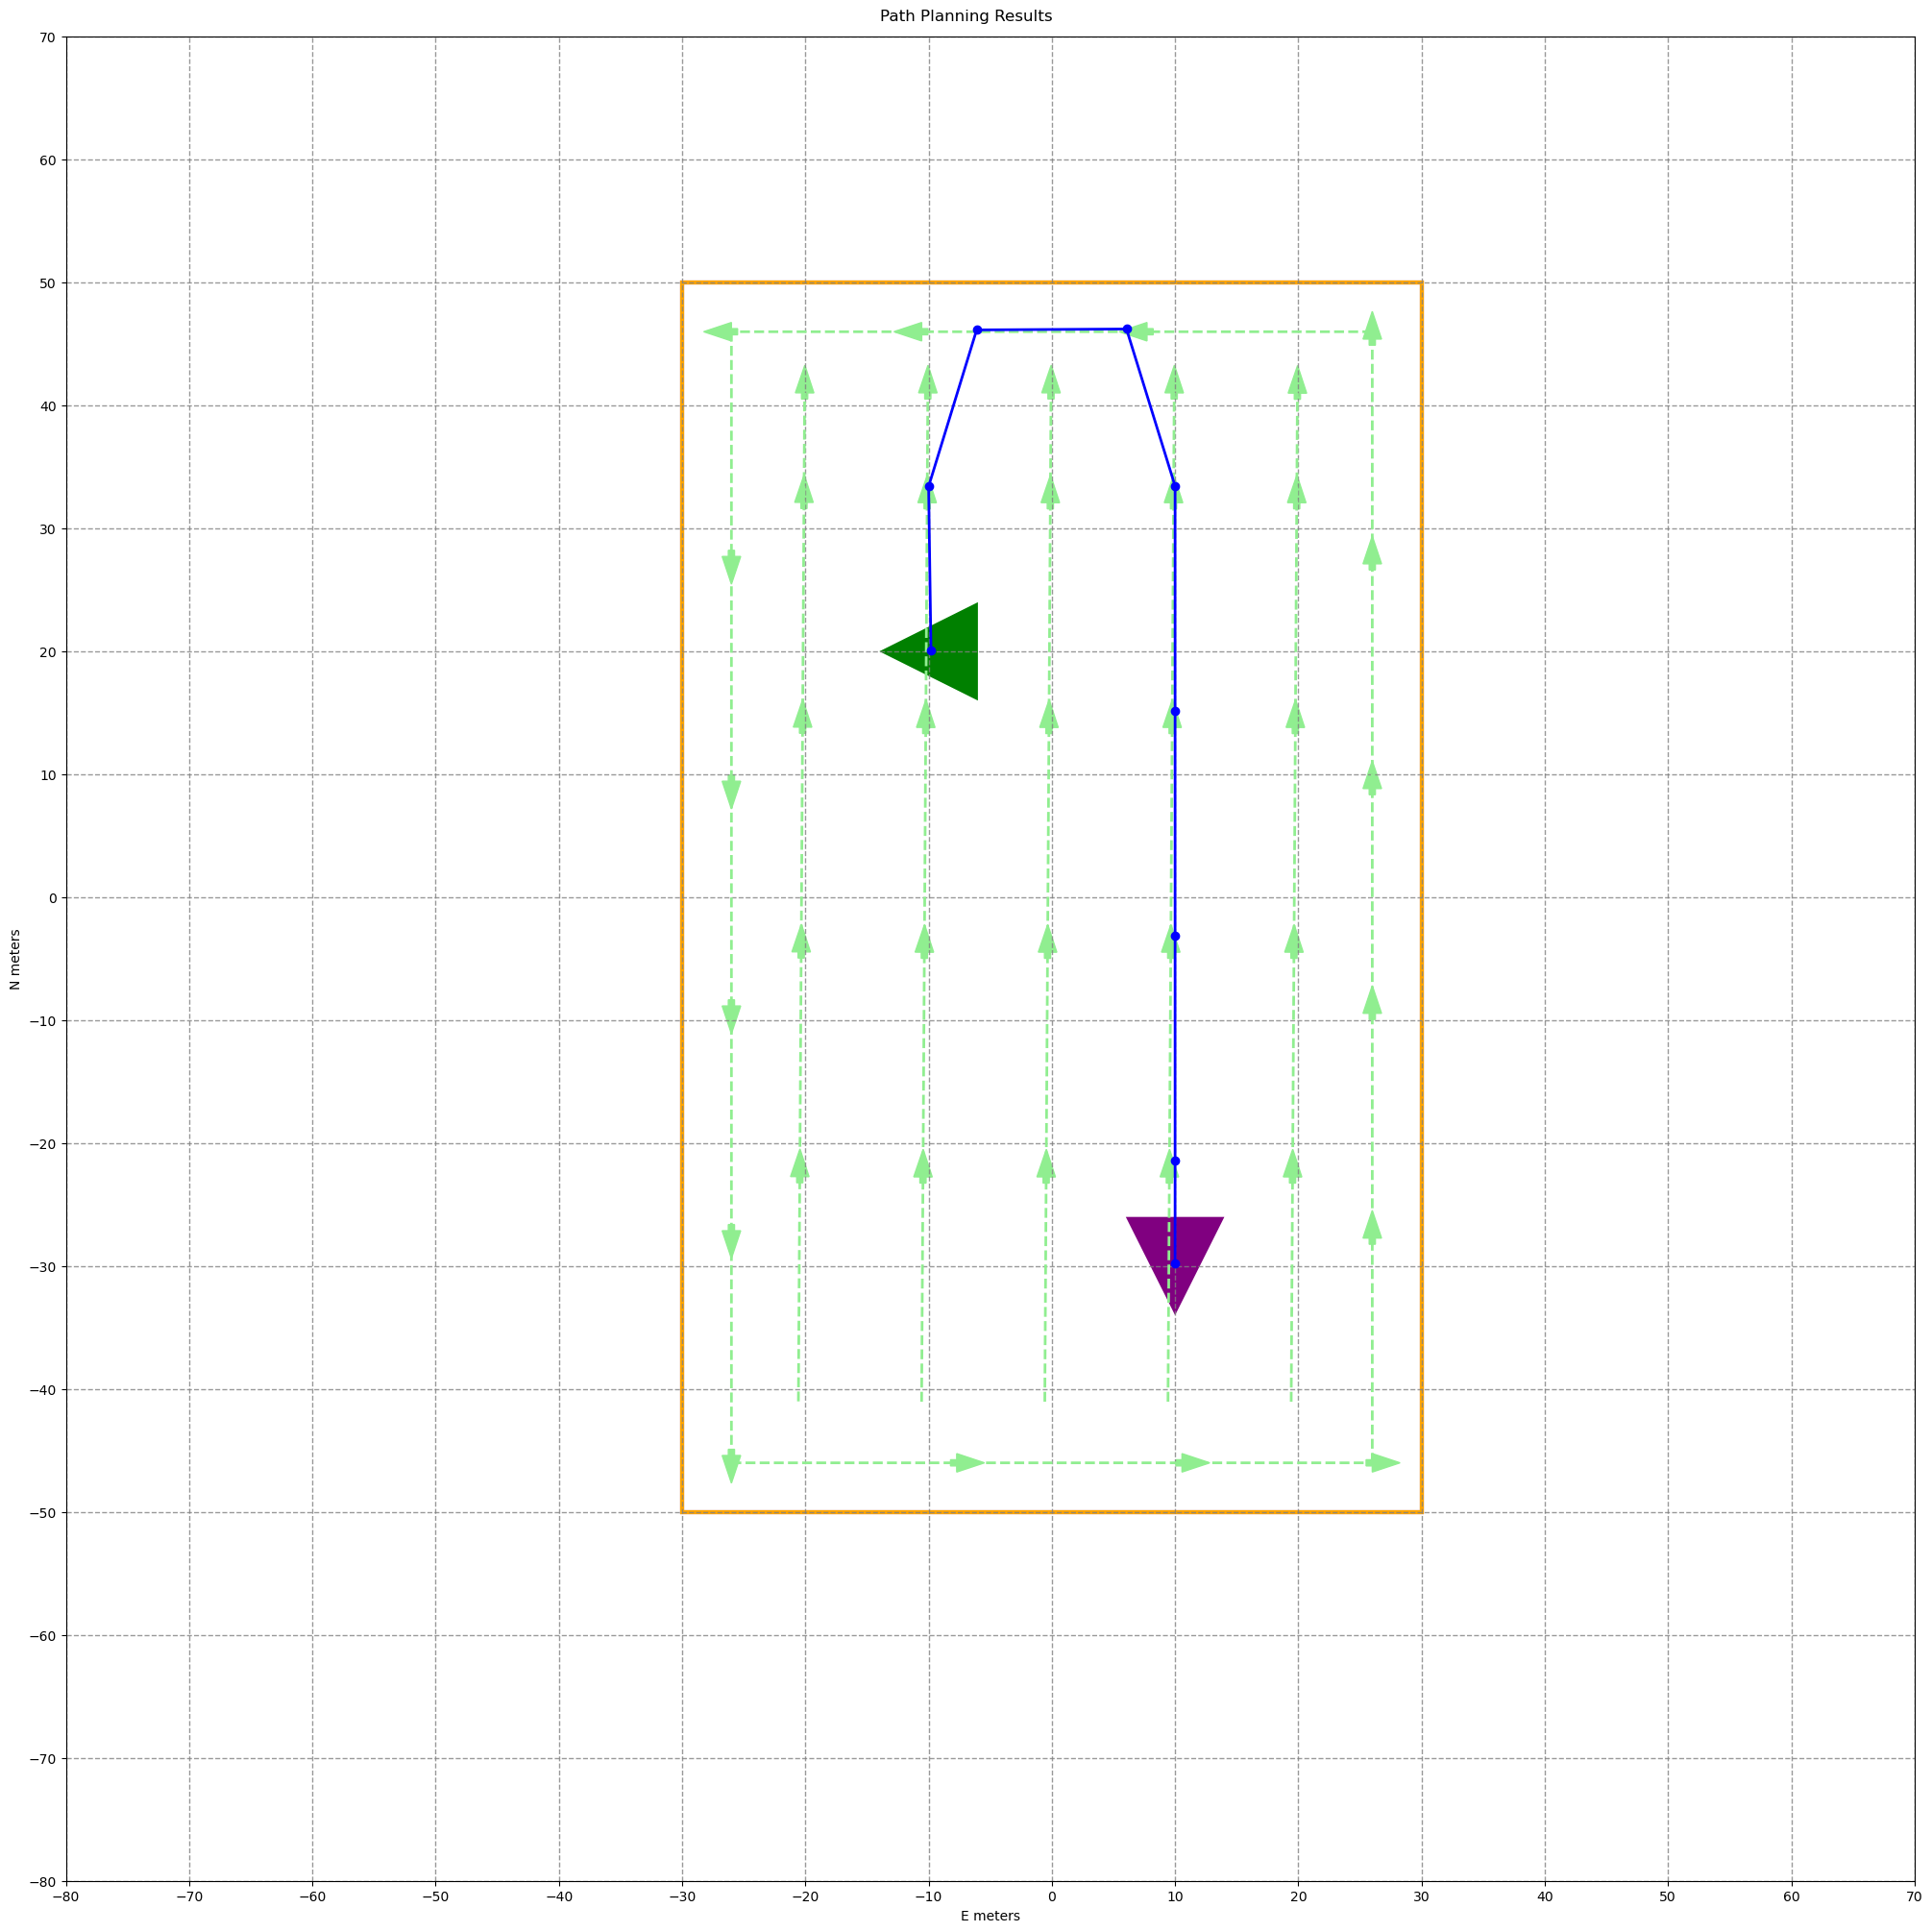

In [7]:
# Planning Scenerio 4.6
# Planner Type: RoadNetwork planner
# Description:
# - Headland and external boundaries overlap
# - Start pose is on a track line
# - Start and End pose angle off by 90 degrees

# Path inputs
start_xy = origin_xy + np.asarray([-1.0 * track_spacing, 2.0 * track_spacing])
end_xy = origin_xy + np.asarray([1.0 * track_spacing, -3.0 * track_spacing])

start_pose_2d = Pose2D(start_xy, 180.0, zone_number, zone_letter)
goal_pose_2d = Pose2D(end_xy, 270, zone_number, zone_letter)

headland_boundaries = [Box2D.compute_bounding_box(obstacles, [-4.0 * track_spacing, 0.0 * track_spacing], **boundaries_plot_attributes)]

environment_inputs = plan_constraints.environment_inputs
plan_constraints.environment_objects.headland_boundaries = headland_boundaries
environment_inputs.HeadlandBoundaries = box2d_to_pypl_points(headland_boundaries, zone_number, zone_letter)
environment_inputs.TopBottom = True


plan_results = generate_road_network_path((start_pose_2d, goal_pose_2d), plan_constraints)
output_path_offset = boundaries[0].top_left - origin_xy
fig, axs = plot_planning_results(plan_constraints,
                                 plan_results,
                                 output_path_offset,
                                 grid_size,
                                 implement_width,
                                 implement_width)

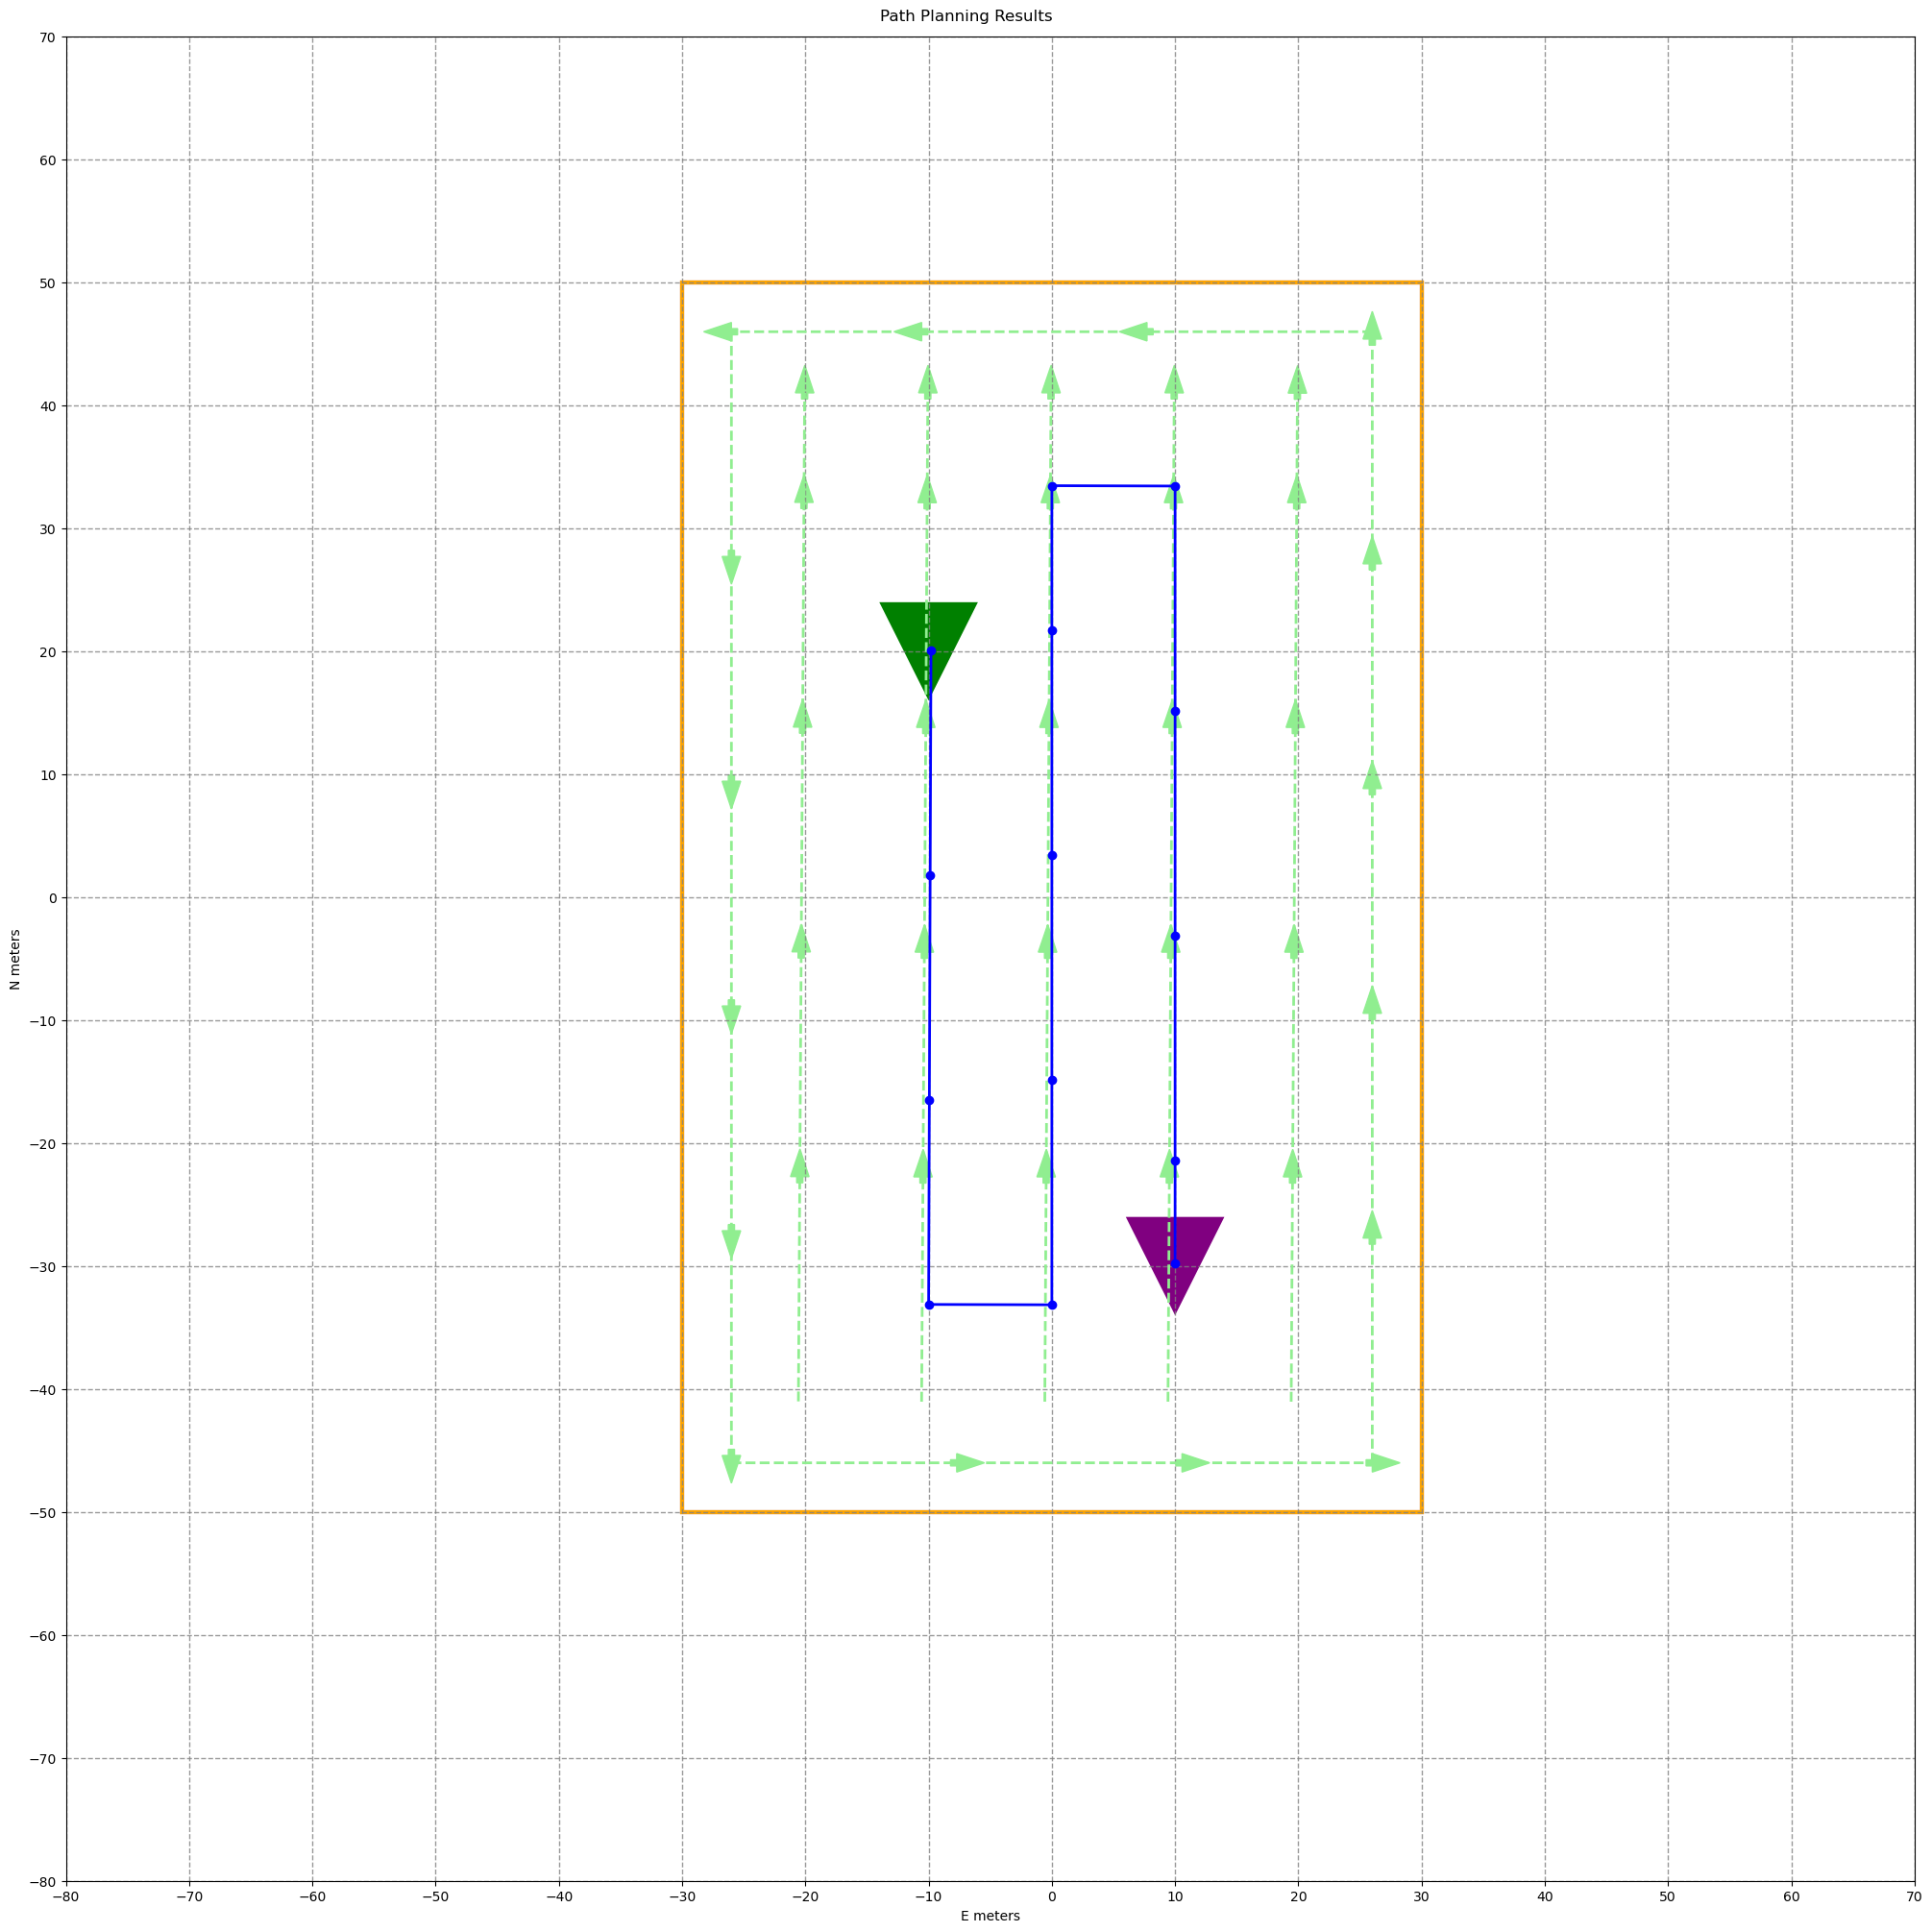

In [8]:
# Planning Scenerio 4.7
# Planner Type: RoadNetwork planner
# Description:
# - Headland and external boundaries overlap
# - Start and End pose angles are the same

# Path inputs
start_xy = origin_xy + np.asarray([-1.0 * track_spacing, 2.0 * track_spacing])
end_xy = origin_xy + np.asarray([1.0 * track_spacing, -3.0 * track_spacing])

start_pose_2d = Pose2D(start_xy, 270, zone_number, zone_letter)
goal_pose_2d = Pose2D(end_xy, 270, zone_number, zone_letter)

headland_boundaries = [Box2D.compute_bounding_box(obstacles, [-4.0 * track_spacing, 0.0 * track_spacing], **boundaries_plot_attributes)]

environment_inputs = plan_constraints.environment_inputs
plan_constraints.environment_objects.headland_boundaries = headland_boundaries
environment_inputs.HeadlandBoundaries = box2d_to_pypl_points(headland_boundaries, zone_number, zone_letter)
environment_inputs.TopBottom = True


plan_results = generate_road_network_path((start_pose_2d, goal_pose_2d), plan_constraints)
output_path_offset = boundaries[0].top_left - origin_xy
fig, axs = plot_planning_results(plan_constraints,
                                 plan_results,
                                 output_path_offset,
                                 grid_size,
                                 implement_width,
                                 implement_width)

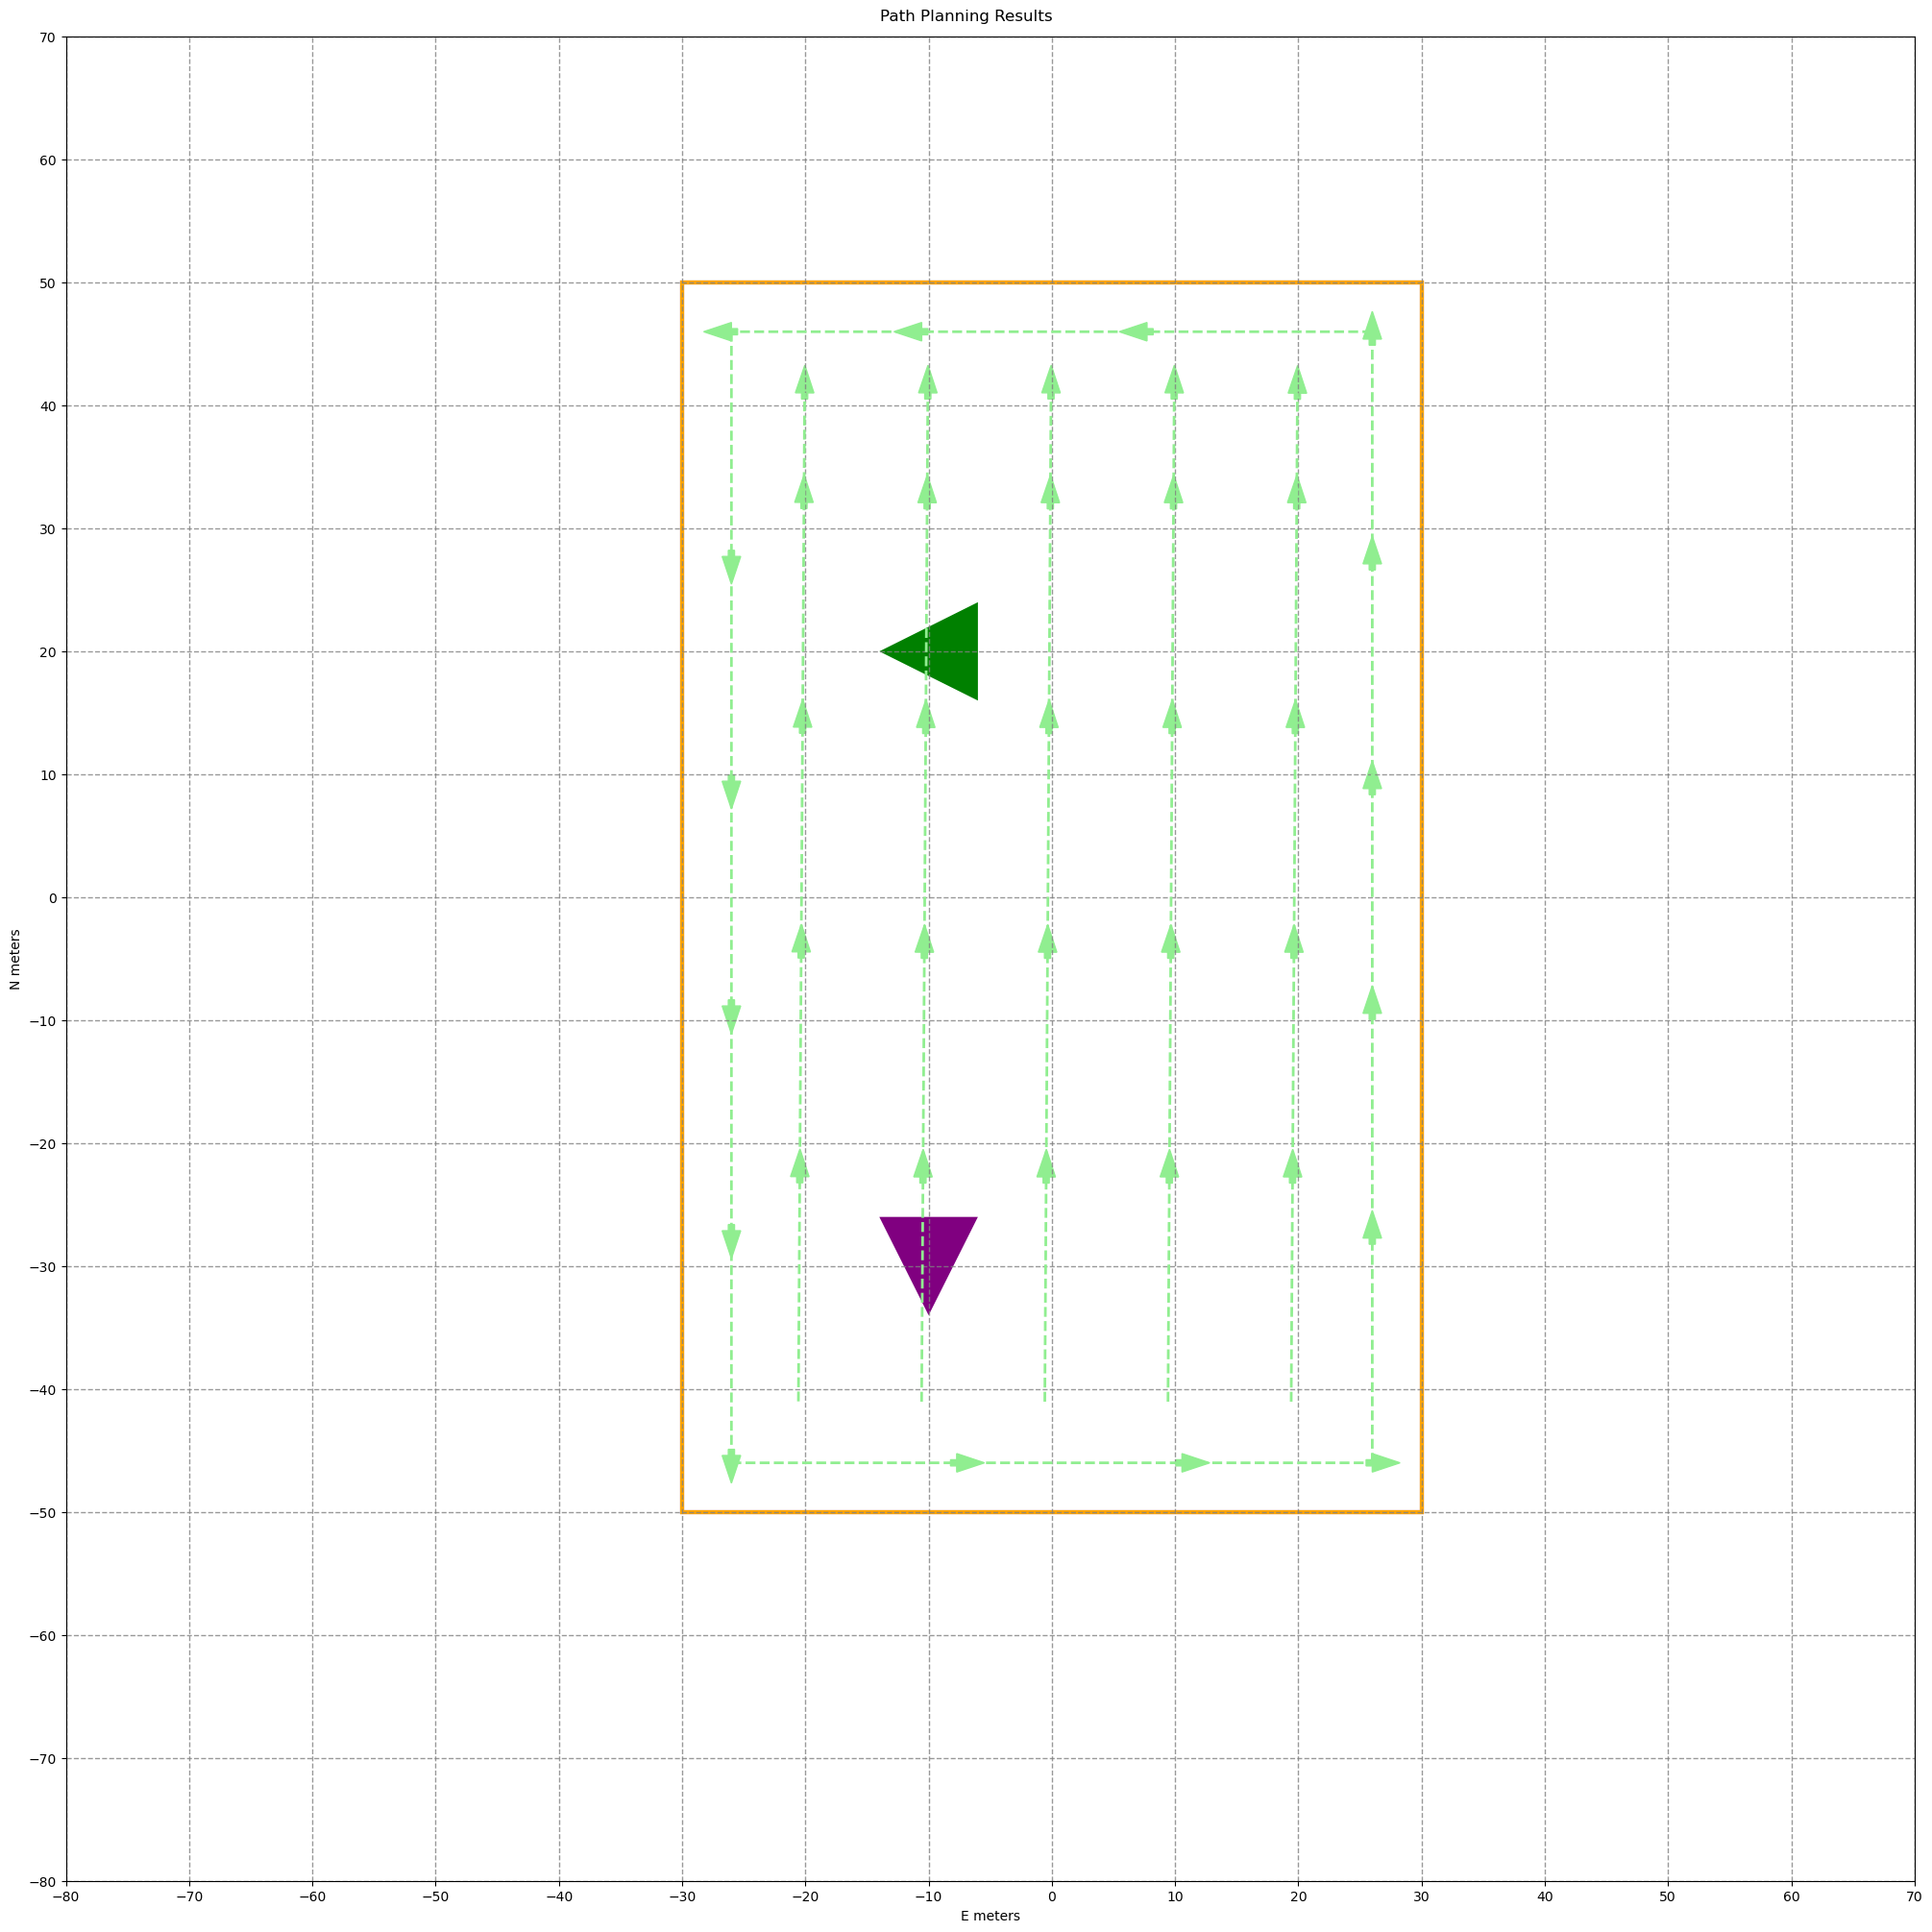

In [9]:
# Planning Scenerio 4.8
# Planner Type: RoadNetwork planner
# Description:
# - Headland and external boundaries overlap
# - Start and End pose angles are the same

# Path inputs
start_xy = origin_xy + np.asarray([-1.0 * track_spacing, 2.0 * track_spacing])
end_xy = origin_xy + np.asarray([-1.0 * track_spacing, -3.0 * track_spacing])

start_pose_2d = Pose2D(start_xy, 180, zone_number, zone_letter)
goal_pose_2d = Pose2D(end_xy, 270, zone_number, zone_letter)

headland_boundaries = [Box2D.compute_bounding_box(obstacles, [-4.0 * track_spacing, 0.0 * track_spacing], **boundaries_plot_attributes)]

environment_inputs = plan_constraints.environment_inputs
plan_constraints.environment_objects.headland_boundaries = headland_boundaries
environment_inputs.HeadlandBoundaries = box2d_to_pypl_points(headland_boundaries, zone_number, zone_letter)
environment_inputs.TopBottom = True


plan_results = generate_road_network_path((start_pose_2d, goal_pose_2d), plan_constraints)
output_path_offset = boundaries[0].top_left - origin_xy
fig, axs = plot_planning_results(plan_constraints,
                                 plan_results,
                                 output_path_offset,
                                 grid_size,
                                 implement_width,
                                 implement_width)

### Observations:
- **This case fails to generate a path**